In [1]:
import functools

import matplotlib.pyplot as plt
import mne
import mne.time_frequency
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
import sklearn.ensemble
import sklearn.impute
import sklearn.metrics

import scipy.fft

In [2]:
# import enums

# Facial expression enum from Mediapipe, that we use to label video data
# enums.FacialExpression

In [3]:
# sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = r"C:\Users\shata\Downloads\YaDiskDL\Компьютер DESKTOP-CJ9FOG3 (2)\Калининград 19.10.2022\Final\Cohort1\table1\Round1\P1\2022.10.19-14.11.55.144.edf"
raw = mne.io.read_raw_edf(sample_data_raw_file, preload=True)

Extracting EDF parameters from C:\Users\shata\Downloads\YaDiskDL\Компьютер DESKTOP-CJ9FOG3 (2)\Калининград 19.10.2022\Final\Cohort1\table1\Round1\P1\2022.10.19-14.11.55.144.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 40624  =      0.000 ...   324.992 secs...


In [4]:
# Example of video artifact detection output - intervals of seconds with actions
artifact_intervals = [(1.0, 1.5, "HEAD_LEFT"), (5.2, 6.4, "STAND"), (9.1, 9.4, "BLINK")]

In [81]:
sample_freq = raw.info["sfreq"]
sample_freq

125.0

In [15]:
raw.info.keys()
raw.n_times

,time,O1,T3,Fp1,Fp2,T4,O2
0,0.000,-5.499916,30.499535,39.499397,47.499275,41.499367,-19.499702
1,0.008,1.499977,18.499718,6.499901,5.499916,20.499687,14.499779
2,0.016,-2.499962,41.499367,-5.499916,-1.499977,63.499031,13.499794
3,0.024,-8.499870,-7.499886,13.499794,24.499626,36.499443,-35.499458
4,0.032,-8.499870,-45.499306,0.499992,0.499992,-52.499199,-15.499763
...,...,...,...,...,...,...,...
40620,324.960,11.499825,-6.499901,-18.499718,-34.499474,20.499687,43.499336
40621,324.968,-26.499596,19.499702,-19.499702,-31.499519,0.499992,-31.499519
40622,324.976,-4.499931,-8.499870,2.499962,4.499931,-14.499779,-44.499321
40623,324.984,43.499336,-69.498939,4.499931,18.499718,-29.499550,62.499046


In [82]:
raw.info

Measurement date,"October 19, 2022 14:11:56 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,2.00 Hz
Lowpass,40.00 Hz


In [83]:
raw_df = raw.to_data_frame()
raw_df

,time,O1,T3,Fp1,Fp2,T4,O2
0,0.000,-5.499916,30.499535,39.499397,47.499275,41.499367,-19.499702
1,0.008,1.499977,18.499718,6.499901,5.499916,20.499687,14.499779
2,0.016,-2.499962,41.499367,-5.499916,-1.499977,63.499031,13.499794
3,0.024,-8.499870,-7.499886,13.499794,24.499626,36.499443,-35.499458
4,0.032,-8.499870,-45.499306,0.499992,0.499992,-52.499199,-15.499763
...,...,...,...,...,...,...,...
40620,324.960,11.499825,-6.499901,-18.499718,-34.499474,20.499687,43.499336
40621,324.968,-26.499596,19.499702,-19.499702,-31.499519,0.499992,-31.499519
40622,324.976,-4.499931,-8.499870,2.499962,4.499931,-14.499779,-44.499321
40623,324.984,43.499336,-69.498939,4.499931,18.499718,-29.499550,62.499046


## Example of removing artifacts from a dataset
Affected channels (depending on detected action) in the time interval are null'ed completely (replaced with NaN).

In [84]:
ACTION_CHANNEL_MAP: dict[str, tuple[str]] = {
    "HEAD_LEFT": ("Fp1", "Fp2"),
    "STAND": ("O1", "T3", "Fp1", "Fp2", "T4", "O2"),
    "BLINK": ("O1", "O2"),
}

exp_df = raw_df.copy()
# exp_df.loc[exp_df["time"].between(artifact_intervals[0][0], artifact_intervals[0][1])]
for start, stop, action in artifact_intervals:
    channels = ACTION_CHANNEL_MAP[action]
    # for channel in channels:
    exp_df.loc[exp_df["time"].between(start, stop), channels] = np.nan

artifacted_mask = functools.reduce(lambda x, y: x | y, [exp_df["time"].between(start, stop) for start, stop, _ in artifact_intervals])
exp_df.loc[artifacted_mask]

,time,O1,T3,Fp1,Fp2,T4,O2
125,1.000,-25.499611,-3.499947,NaN,NaN,-22.499657,-3.499947
126,1.008,2.499962,-44.499321,NaN,NaN,-22.499657,2.499962
127,1.016,8.499870,-45.499306,NaN,NaN,0.499992,22.499657
128,1.024,-32.499504,-18.499718,NaN,NaN,10.499840,-19.499702
129,1.032,-39.499397,1.499977,NaN,NaN,-18.499718,-27.499580
...,...,...,...,...,...,...,...
1171,9.368,NaN,-50.499229,-0.499992,18.499718,25.499611,NaN
1172,9.376,NaN,0.499992,7.499886,20.499687,4.499931,NaN
1173,9.384,NaN,22.499657,-6.499901,-27.499580,27.499580,NaN
1174,9.392,NaN,-23.499641,-20.499687,-25.499611,31.499519,NaN


## Imputing missing channels
- Use multiple imputation to fill in missing channels where some channels are present in the time inteval
- Use interpolation to fill in missing channels where no channels are present in the time interval

In [85]:
# nan_mask = exp_df.isna()
nan_index = (exp_df.isna() == True).index
nan_index

RangeIndex(start=0, stop=40625, step=1)

In [70]:
estimator = sklearn.ensemble.RandomForestRegressor(n_estimators=100, random_state=0)
# Uses bayesian ridge regression by default, not very good results by the look of them. But subsecond fast
# imputer = sklearn.impute.IterativeImputer(max_iter=10, random_state=0)
imputer = sklearn.impute.IterativeImputer(estimator, max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(exp_df)
imputed_df = pd.DataFrame(imputed_values, columns=exp_df.columns)

KeyboardInterrupt: 

In [65]:
# artifact_intervals = [(1.0, 1.5, "HEAD_LEFT"), (5.2, 6.4, "STAND"), (9.1, 9.4, "BLINK")]
# imputed_df[artifacted_mask]
# exp_df[exp_df["time"].between(9.0, 9.2)]
imputed_df[imputed_df["time"].between(9.0, 9.2)]

,time,O1,T3,Fp1,Fp2,T4,O2
1125,9.000,27.499580,-57.499123,-26.499596,-33.499489,71.498909,12.499809
1126,9.008,61.499062,-114.498253,-16.499748,-21.499672,26.499596,77.498817
1127,9.016,-0.499992,-12.499809,11.499825,29.499550,13.499794,6.499901
1128,9.024,4.499931,40.499382,0.499992,8.499870,21.499672,-28.499565
1129,9.032,48.499260,-85.498695,-49.499245,-51.499214,-12.499809,2.499962
1130,9.040,-36.499443,-70.498924,-57.499123,-58.499107,-5.499916,-96.498528
1131,9.048,-55.499153,49.499245,-20.499687,-12.499809,-8.499870,-123.498116
1132,9.056,47.499275,-7.499886,-19.499702,-4.499931,-14.499779,36.499443
1133,9.064,37.499428,-53.499184,-40.499382,-52.499199,47.499275,36.499443
1134,9.072,-19.499702,32.499504,-25.499611,-46.499290,20.499687,-82.498741


**Preliminary results**
- When imputing some missing channels, the imputed values seem to be quite a bit smaller (by absolute value) than the original values - why?
- When imputing all missing channels, the imputed values are very small (by absolute value), around (-0.1, 0.1) - doesn't seem to be a good idea. Need to use interpolation instead?

Idea: find out imputation accuracy with a metric? Although this doesn't seem to be a good idea, since EEG data and artifacts are fairly random.

In [41]:
imputed_values
# exp_df[exp_df.isna()]

array([[ 0.00000000e+00, -5.49991608e+00,  3.04995346e+01, ...,
         4.74992752e+01,  4.14993668e+01, -1.94997024e+01],
       [ 8.00000000e-03,  1.49997711e+00,  1.84997177e+01, ...,
         5.49991608e+00,  2.04996872e+01,  1.44997787e+01],
       [ 1.60000000e-02, -2.49996185e+00,  4.14993668e+01, ...,
        -1.49997711e+00,  6.34990311e+01,  1.34997940e+01],
       ...,
       [ 3.24976000e+02, -4.49993133e+00, -8.49987030e+00, ...,
         4.49993133e+00, -1.44997787e+01, -4.44993210e+01],
       [ 3.24984000e+02,  4.34993362e+01, -6.94989395e+01, ...,
         1.84997177e+01, -2.94995499e+01,  6.24990463e+01],
       [ 3.24992000e+02, -1.04998398e+01,  1.14998245e+01, ...,
        -1.34997940e+01,  2.84995651e+01, -1.84997177e+01]])

In [74]:
mne.time_frequency.Spectrum(
    raw,
    fmin=1,
    fmax=50,
    method="welch",
    tmin=0,
    tmax=None,
    picks=None,
    proj=False,
    reject_by_annotation=False,
    exclude="bads",
    remove_dc=False,
    n_jobs=1,
).get_data()

Effective window size : 2.048 (s)


array([[1.26817646e-10, 4.99051992e-10, 7.81041820e-10, 5.61328734e-10,
        4.35770759e-10, 3.12858724e-10, 2.17782133e-10, 1.54518417e-10,
        1.31515852e-10, 9.62112710e-11, 8.66490790e-11, 7.31194873e-11,
        4.76258642e-11, 3.64602344e-11, 3.24528257e-11, 2.38438398e-11,
        2.10896280e-11, 1.98145643e-11, 1.98984180e-11, 1.89105409e-11,
        1.80684184e-11, 2.02654411e-11, 2.17501666e-11, 1.99397916e-11,
        1.56476355e-11, 1.44282533e-11, 1.44564144e-11, 1.26545496e-11,
        1.27670133e-11, 1.26819003e-11, 1.31460019e-11, 1.54820255e-11,
        1.43772207e-11, 1.15190816e-11, 1.11839842e-11, 1.35863172e-11,
        1.12373636e-11, 1.33243044e-11, 1.36733648e-11, 1.24216780e-11,
        1.36417225e-11, 1.39385082e-11, 1.21171988e-11, 1.18931568e-11,
        1.42181559e-11, 1.47093577e-11, 1.43267820e-11, 1.95184623e-11,
        2.43221738e-11, 1.61828469e-11, 1.68349879e-11, 1.61853485e-11,
        1.67394428e-11, 1.84373334e-11, 1.82752827e-11, 1.941410

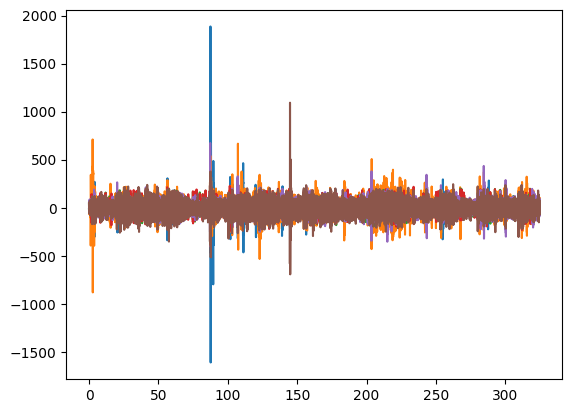

In [74]:
plt.plot(imputed_df["time"], imputed_df["O1"])
plt.plot(imputed_df["time"], imputed_df["T3"])
plt.plot(imputed_df["time"], imputed_df["Fp1"])
plt.plot(imputed_df["time"], imputed_df["Fp2"])
plt.plot(imputed_df["time"], imputed_df["T4"])
plt.plot(imputed_df["time"], imputed_df["O2"])
plt.show()

в npd файле ts в unix миллисекундах

Мы хотим взять данные только ЭЭГ.
Мы хотим определить места выбросов по амплитуде (мкВ) - что больше N мкВ (некого бейзлайна) - это артефакт.
Мы хотим восстановить отфильтрованные части ЭЭГ (множ. импутация, интерполяция, убирание компонента волны, ...)

In [86]:
raw

Measurement date,"October 19, 2022 14:11:56 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,2.00 Hz
Lowpass,40.00 Hz


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 207 samples (1.656 s)



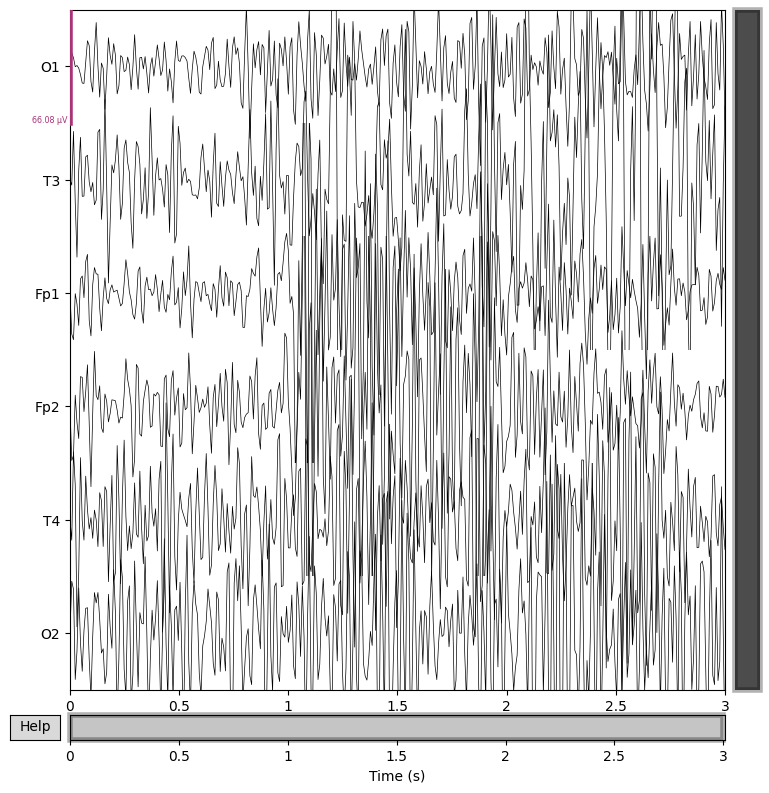

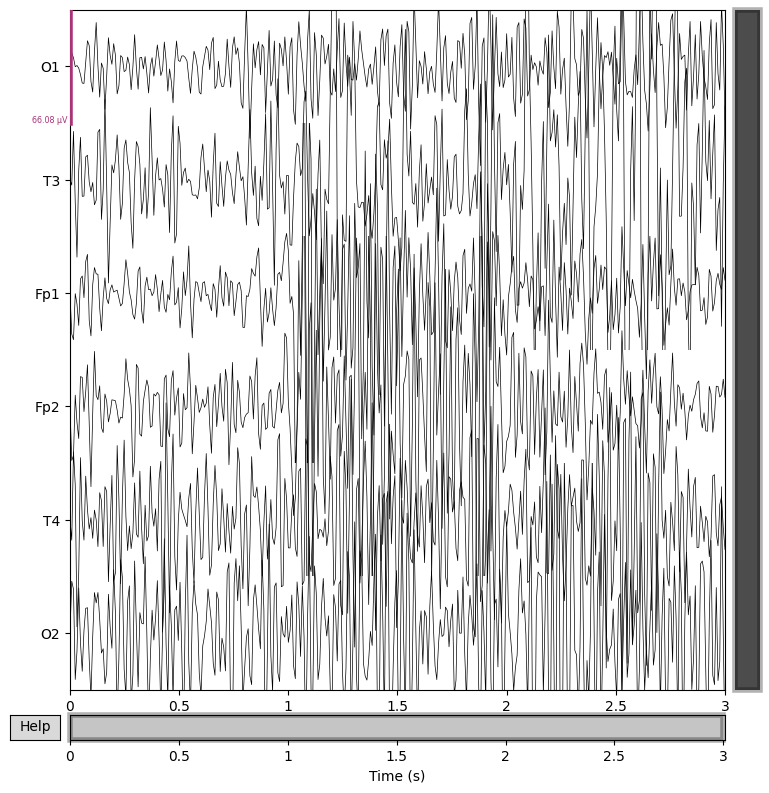

In [207]:
raw.copy().filter(l_freq=8, h_freq=None).crop(tmax=3).plot(n_channels=6, scalings='auto', title='Auto-scaled Data from arrays')

Creating RawArray with float64 data, n_channels=6, n_times=40624
    Range : 0 ... 40623 =      0.000 ...   324.984 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 207 samples (1.656 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter

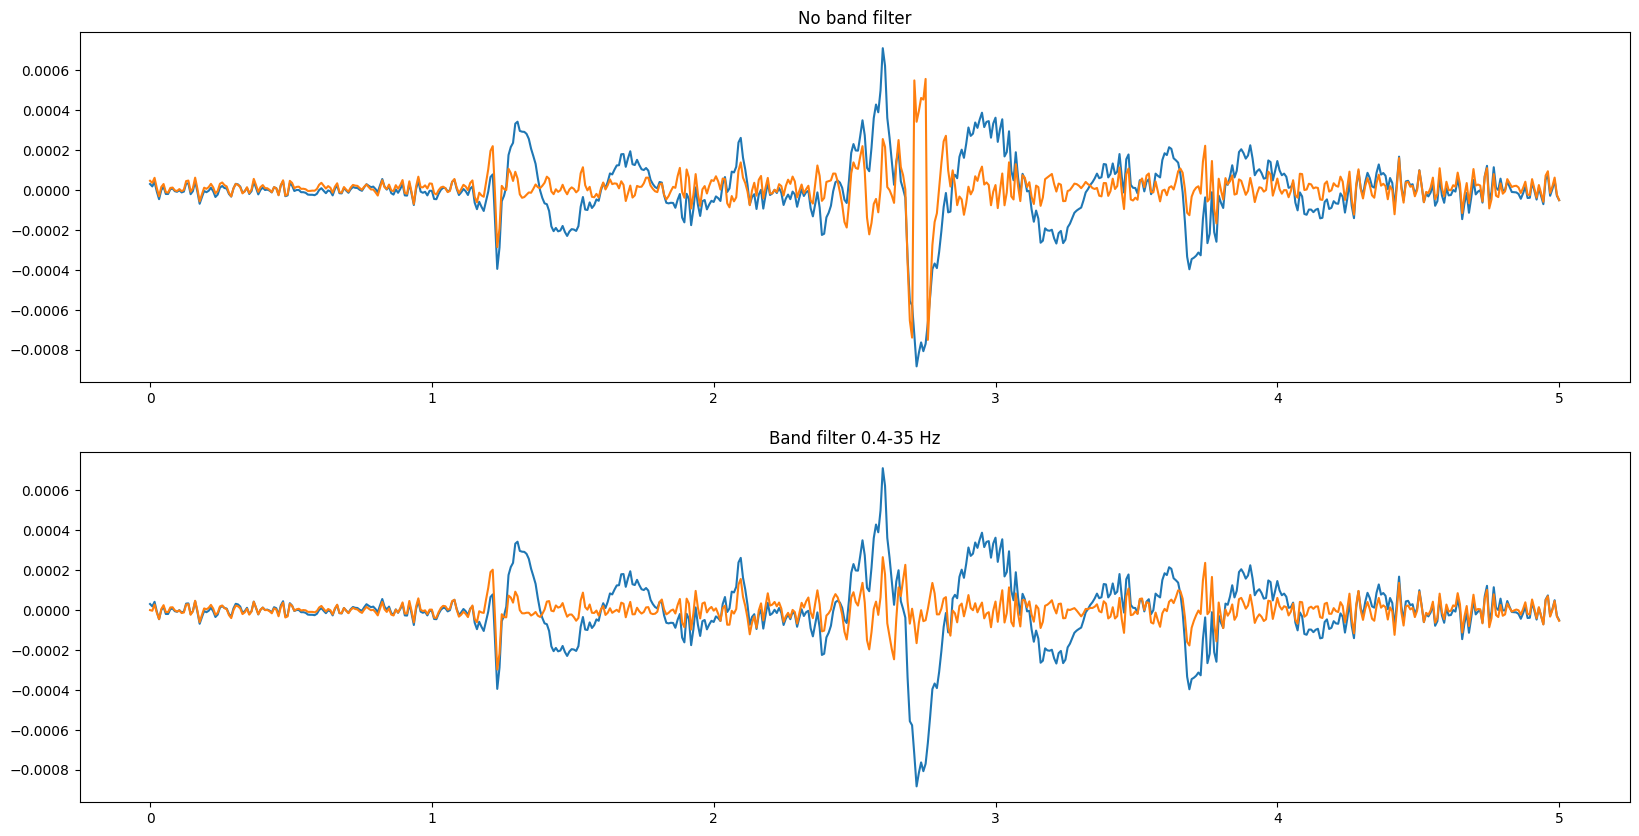

In [202]:
raw_df = raw.to_data_frame()
raw_df = raw_df.iloc[:-1, 1:]
ch_names = raw_df.columns.tolist()
ch_types = ["eeg"] * len(ch_names)
SAMPLE_RATE = raw.info["sfreq"]
N = raw_df.shape[0]

filtered_df = raw_df.copy()
for channel in ch_names:
# for channel in [ch_names[1]]:
    chan = raw_df[channel].values
    normalized_tone = np.int16(((chan - chan.mean()) / chan.max()) * 32767)
    xf = scipy.fft.rfftfreq(N, 1 / SAMPLE_RATE)
    yf = scipy.fft.rfft(normalized_tone)
    # plt.plot(xf, np.abs(yf))
    # plt.show()

    # Максимальная частота составляет половину частоты дискретизации
    points_per_freq = len(xf) / (SAMPLE_RATE / 2)

    TARGET_MIN_FREQ = 0.1
    TARGET_MAX_FREQ = 8
    min_target_idx = int(points_per_freq * TARGET_MIN_FREQ)
    max_target_idx = int(points_per_freq * TARGET_MAX_FREQ)
        
    # Обнулим yf для индексов около целевой частоты
    # new_yf = yf.copy()        
    yf[min_target_idx-2:max_target_idx+2] = 0

    # plt.plot(xf, np.abs(new_yf))
    # plt.show()

    # new_sig = scipy.fft.irfft(new_yf)
    new_sig = scipy.fft.irfft(yf)
    filtered_df[channel] = new_sig / 43623701.42716775

    # fig, axes = plt.subplots(2)
    # axes[0].plot(chan)
    # axes[0].set_title("Original")
    # axes[1].plot(new_sig / 40)
    # axes[1].set_title("Filtered")
    # plt.show()

new_info = mne.create_info(ch_names, sfreq=SAMPLE_RATE, ch_types=ch_types)
new_info

filtered_raw = mne.io.RawArray(np.transpose(filtered_df.values), new_info)

fig, axes = plt.subplots(2, 1, figsize=(20, 10))
CUTOFF = 500

ax1 = axes[0]
raw_mod = raw.copy().crop(tmax=5).pick_channels(["T3"])
filtered_raw_mod = filtered_raw.copy().crop(tmax=5).pick_channels(["T3"])
ax1.plot(raw_mod.times, raw_mod.get_data().T)
ax1.plot(filtered_raw_mod.times, filtered_raw_mod.get_data().T)
ax1.set_title("No band filter")

ax2 = axes[1]
# raw_mod_filt = raw.copy().filter(l_freq=0.4, h_freq=35).crop(tmax=5).pick_channels(["T3"])
raw_mod_filt = raw.copy().filter(l_freq=8, h_freq=None).crop(tmax=5).pick_channels(["T3"])
# filtered_raw_mod_filt = filtered_raw.copy().filter(l_freq=0.4, h_freq=35).crop(tmax=5).pick_channels(["T3"])
filtered_raw_mod_filt = filtered_raw.copy().filter(l_freq=8, h_freq=None).crop(tmax=5).pick_channels(["T3"])
ax2.plot(raw_mod.times, raw_mod.get_data().T)
ax2.plot(raw_mod_filt.times, raw_mod_filt.get_data().T)
# ax2.plot(filtered_raw_mod_filt.times, filtered_raw_mod_filt.get_data().T)
ax2.set_title("Band filter 0.4-35 Hz")
plt.show()
# filtered_raw.plot(duration=3, n_channels=len(ch_names), scalings='auto', title='Auto-scaled Data from arrays', show=False)
# raw.plot(duration=3, n_channels=6, scalings='auto', title='Auto-scaled Data from arrays', show=False)
# filtered_raw.pick_channels(["T3"]).plot(duration=3, n_channels=len(ch_names), scalings='auto', title='Auto-scaled Data from arrays',)

In [173]:
4306531804.89 / 98.72

43623701.42716775

In [ ]:
fig, axes = plt.subplots()

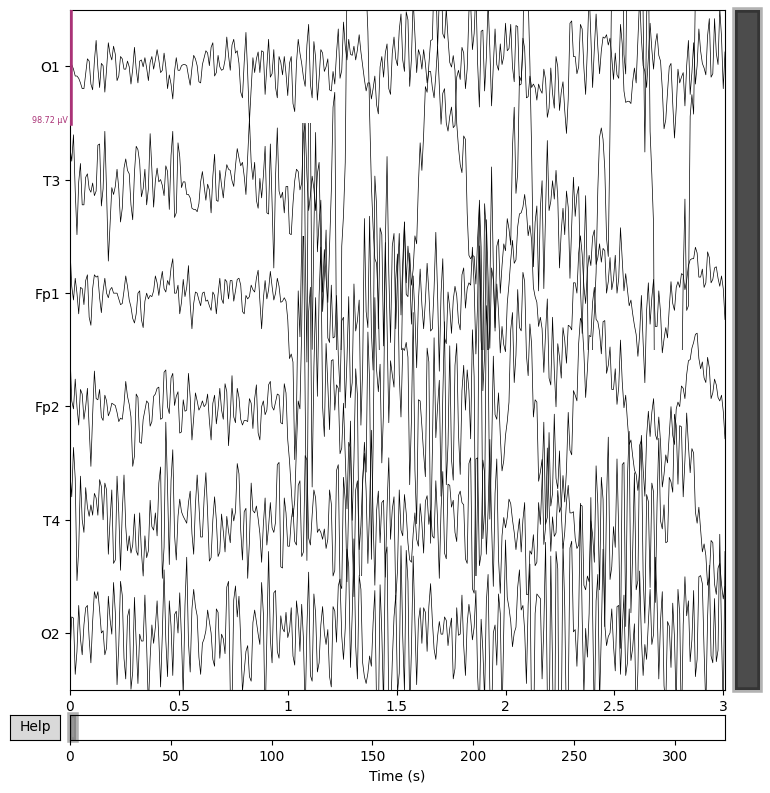

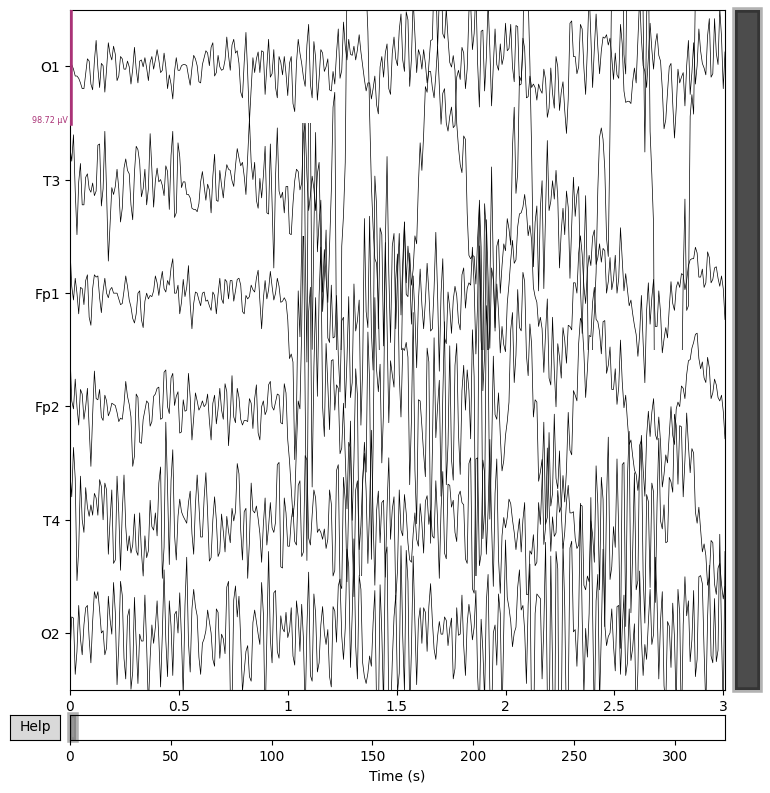

In [165]:
raw.plot(duration=3, n_channels=6, scalings='auto', title='Auto-scaled Data from arrays',)

In [163]:
filtered_df

,O1,T3,Fp1,Fp2,T4,O2
0,-5.499916,1923.308948,39.499397,47.499275,41.499367,-19.499702
1,1.499977,1464.564056,6.499901,5.499916,20.499687,14.499779
2,-2.499962,2581.341153,-5.499916,-1.499977,63.499031,13.499794
3,-8.499870,334.740275,13.499794,24.499626,36.499443,-35.499458
4,-8.499870,-1449.273889,0.499992,0.499992,-52.499199,-15.499763
...,...,...,...,...,...,...
40619,1.499977,-392.866080,0.499992,13.499794,0.499992,-17.499733
40620,11.499825,-219.835317,-18.499718,-34.499474,20.499687,43.499336
40621,-26.499596,1059.293317,-19.499702,-31.499519,0.499992,-31.499519
40622,-4.499931,-118.912734,2.499962,4.499931,-14.499779,-44.499321


In [108]:
chan.shape[0]

40625

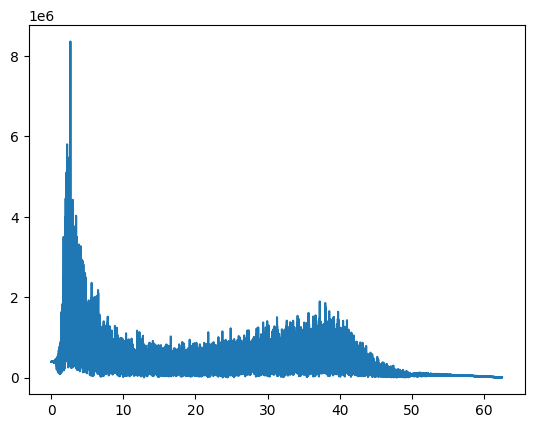

In [187]:
chan = raw.to_data_frame()["T3"]

SAMPLE_RATE = 125  # Гц
# DURATION = 5  # Секунды
N = chan.shape[0]

normalized_tone = np.int16(((chan - chan.mean()) / chan.max()) * 32767)
xf = scipy.fft.rfftfreq(N, 1 / SAMPLE_RATE)
yf = scipy.fft.rfft(normalized_tone)

plt.plot(xf, np.abs(yf))
plt.show()

In [113]:
len(xf) / (SAMPLE_RATE / 2)

325.008

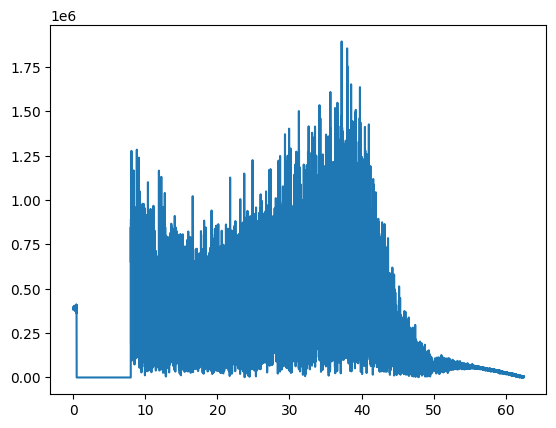

In [188]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (SAMPLE_RATE / 2)
# Наша целевая частота - 4000 Гц
TARGET_FREQ = 5
target_idx = int(points_per_freq * TARGET_FREQ)

TARGET_MIN_FREQ = 0.5
TARGET_MAX_FREQ = 8
min_target_idx = int(points_per_freq * TARGET_MIN_FREQ)
max_target_idx = int(points_per_freq * TARGET_MAX_FREQ)
    
# Обнулим yf для индексов около целевой частоты
new_yf = yf.copy()        
new_yf[min_target_idx-2:max_target_idx+2] = 0

plt.plot(xf, np.abs(new_yf))
plt.show()

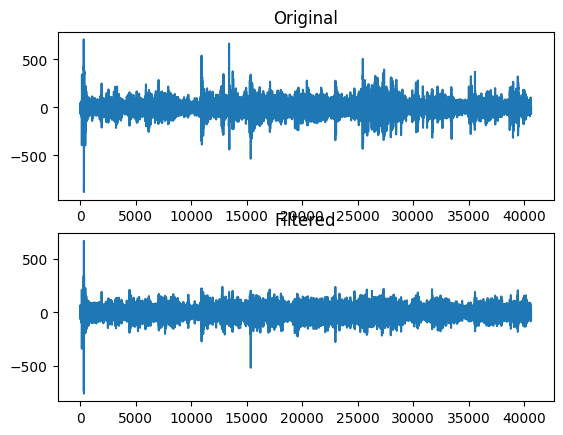

In [145]:
new_sig = scipy.fft.irfft(new_yf)

fig, axes = plt.subplots(2)
axes[0].plot(chan)
axes[0].set_title("Original")
axes[1].plot(new_sig / 40)
axes[1].set_title("Filtered")
plt.show()

In [140]:
ch_names = ["T3"]
ch_types = ["eeg"]
new_info = mne.create_info(ch_names, sfreq=SAMPLE_RATE, ch_types=ch_types)
new_info

filtered_raw = mne.io.RawArray([new_sig / 40], new_info)
filtered_raw

Creating RawArray with float64 data, n_channels=1, n_times=40624
    Range : 0 ... 40623 =      0.000 ...   324.984 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,1 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


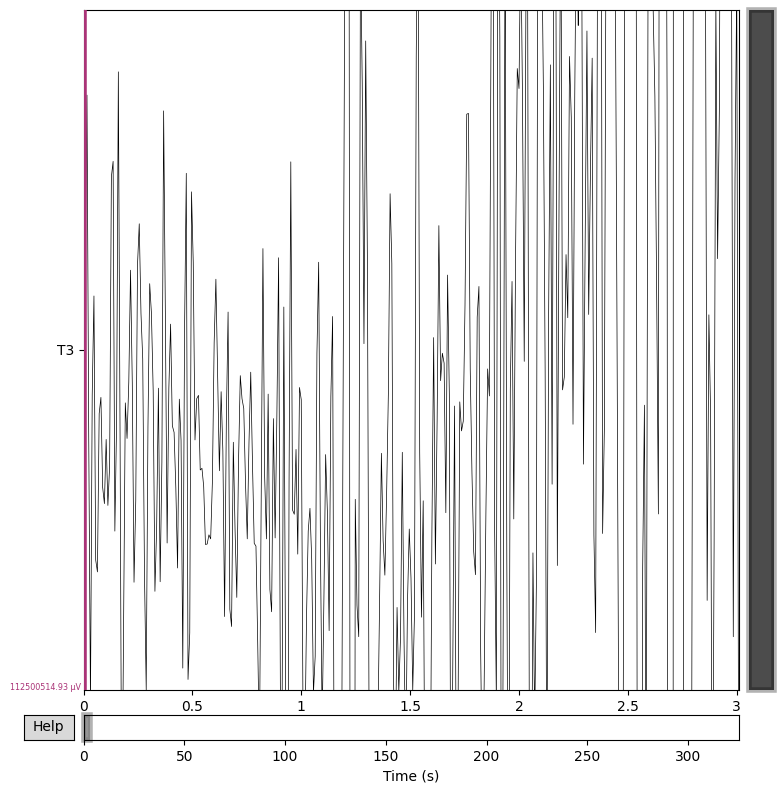

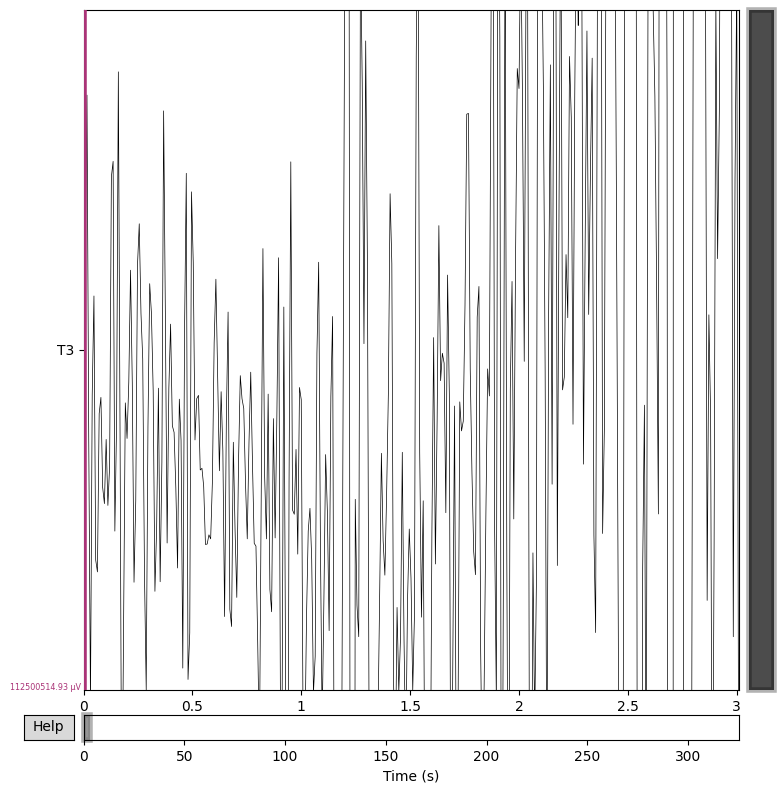

In [142]:
filtered_raw.plot(duration=3, n_channels=1, scalings=0.00005, title='Auto-scaled Data from arrays',)

In [83]:
raw.info
# берем utc measurement date в качестве начальный таймстемп

Measurement date,"October 19, 2022 14:11:56 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,2.00 Hz
Lowpass,40.00 Hz


In [87]:
raw.to_data_frame()

,time,O1,T3,Fp1,Fp2,T4,O2
0,0.000,-5.499916,30.499535,39.499397,47.499275,41.499367,-19.499702
1,0.008,1.499977,18.499718,6.499901,5.499916,20.499687,14.499779
2,0.016,-2.499962,41.499367,-5.499916,-1.499977,63.499031,13.499794
3,0.024,-8.499870,-7.499886,13.499794,24.499626,36.499443,-35.499458
4,0.032,-8.499870,-45.499306,0.499992,0.499992,-52.499199,-15.499763
...,...,...,...,...,...,...,...
40620,324.960,11.499825,-6.499901,-18.499718,-34.499474,20.499687,43.499336
40621,324.968,-26.499596,19.499702,-19.499702,-31.499519,0.499992,-31.499519
40622,324.976,-4.499931,-8.499870,2.499962,4.499931,-14.499779,-44.499321
40623,324.984,43.499336,-69.498939,4.499931,18.499718,-29.499550,62.499046


In [80]:
raw.get_data()

array([[-5.49991608e-06,  1.49997711e-06, -2.49996185e-06, ...,
        -4.49993133e-06,  4.34993362e-05, -1.04998398e-05],
       [ 3.04995346e-05,  1.84997177e-05,  4.14993668e-05, ...,
        -8.49987030e-06, -6.94989395e-05,  1.14998245e-05],
       [ 3.94993973e-05,  6.49990082e-06, -5.49991608e-06, ...,
         2.49996185e-06,  4.49993133e-06, -1.34997940e-05],
       [ 4.74992752e-05,  5.49991608e-06, -1.49997711e-06, ...,
         4.49993133e-06,  1.84997177e-05, -1.34997940e-05],
       [ 4.14993668e-05,  2.04996872e-05,  6.34990311e-05, ...,
        -1.44997787e-05, -2.94995499e-05,  2.84995651e-05],
       [-1.94997024e-05,  1.44997787e-05,  1.34997940e-05, ...,
        -4.44993210e-05,  6.24990463e-05, -1.84997177e-05]])

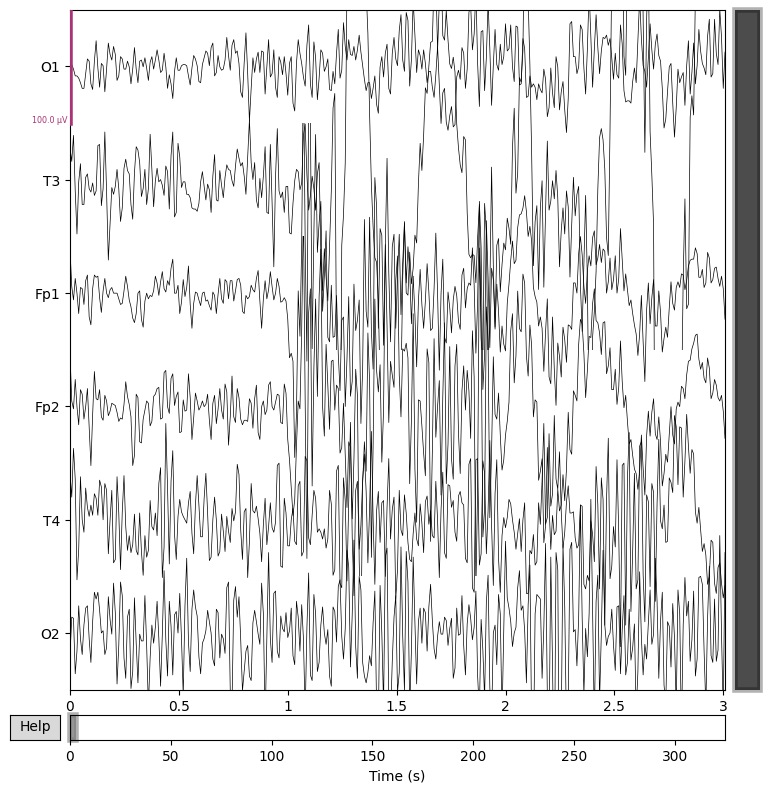

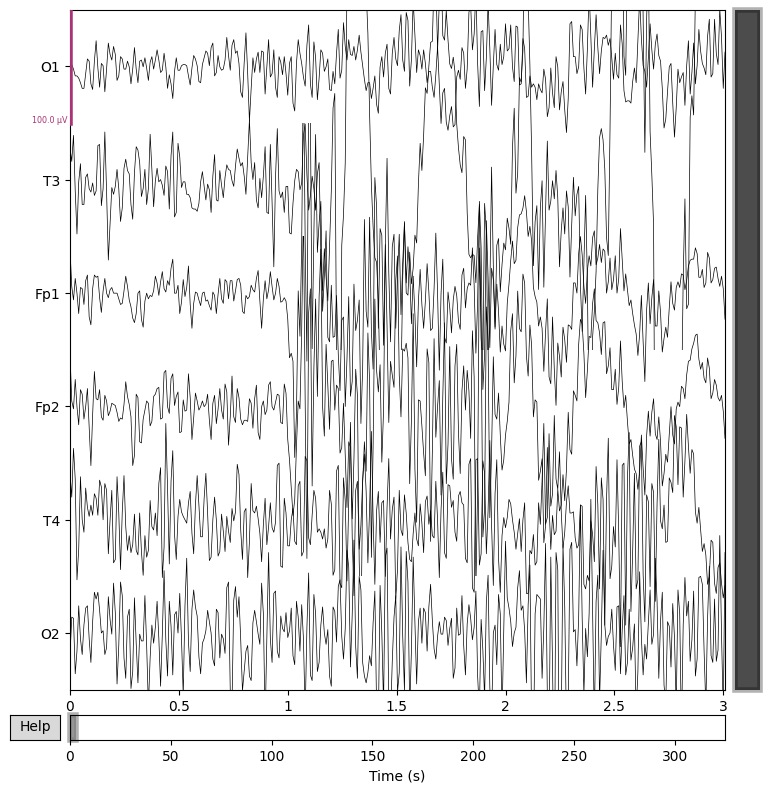

In [135]:
raw.plot(duration=3, n_channels=6, scalings=0.00005, title='Auto-scaled Data from arrays',)

In [60]:
raw.annotations

<Annotations | 0 segments>

In [4]:
print([ch["kind"] for ch in raw.info["chs"]])

[2 (FIFFV_EEG_CH), 2 (FIFFV_EEG_CH), 2 (FIFFV_EEG_CH), 2 (FIFFV_EEG_CH), 2 (FIFFV_EEG_CH), 2 (FIFFV_EEG_CH)]


In [5]:
# raw.plot(duration=0.5, n_channels=6, highpass=2, lowpass=40)

Effective window size : 16.384 (s)


C:\Users\shata\AppData\Local\Temp\ipykernel_63240\3193868445.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)
c:\Projects\Panga\eeg-artifact-filtering\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


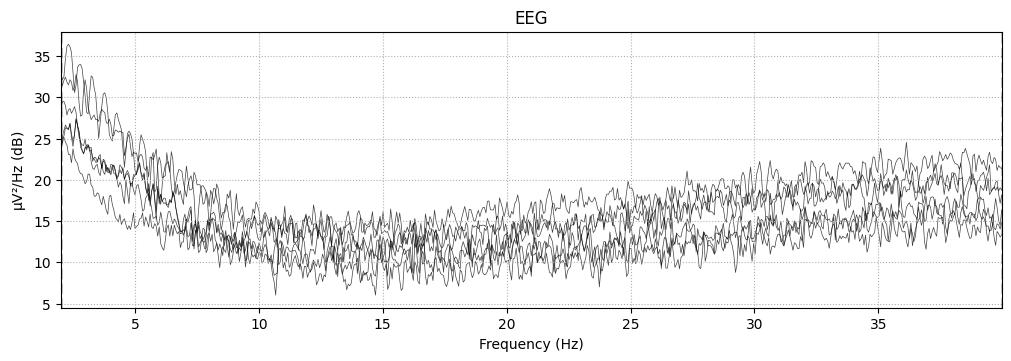

In [44]:
raw.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)

In [45]:
raw_avg_ref = raw.copy().set_eeg_reference(ref_channels='average')
# eog_epochs = mne.preprocessing.create_eeg_epochs(raw_avg_ref)  # create eog epochs
# eog_epochs.average().plot_joint() #  plot eog activity in source space and topography

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Effective window size : 16.384 (s)


C:\Users\shata\AppData\Local\Temp\ipykernel_63240\2658807575.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_avg_ref.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)
c:\Projects\Panga\eeg-artifact-filtering\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


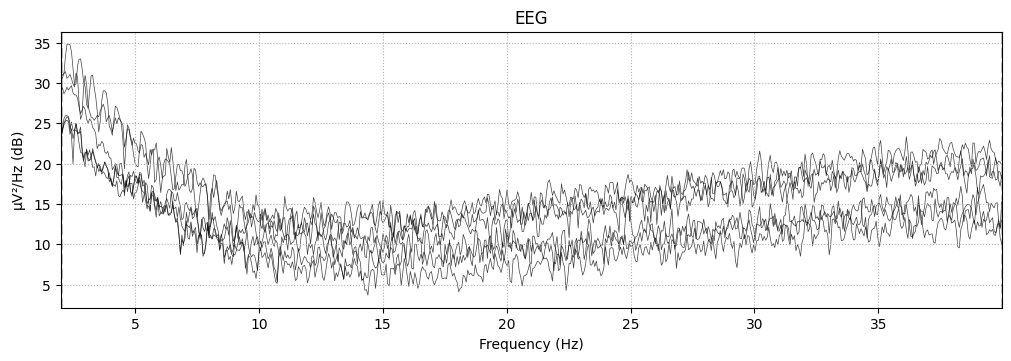

In [46]:
raw_avg_ref.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)

In [8]:
raw_filtered = raw_avg_ref.copy().filter(
    l_freq=2.,
    h_freq=40.,  # lfreq = lower cut-off frequency; hfreq =upper cut-off frequency
    picks=['eeg'],  # which channel to filter by type
    filter_length='auto',
    l_trans_bandwidth='auto',
    h_trans_bandwidth='auto',
    method='fir',  # finite response filter; MNE default
    phase='zero',
    fir_window='hamming',  # i.e. our "smoothing function" (MNE-default)
    fir_design='firwin',
    n_jobs=1,
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 207 samples (1.656 s)



Effective window size : 16.384 (s)


C:\Users\shata\AppData\Local\Temp\ipykernel_63240\2788817948.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_filtered.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)
c:\Projects\Panga\eeg-artifact-filtering\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


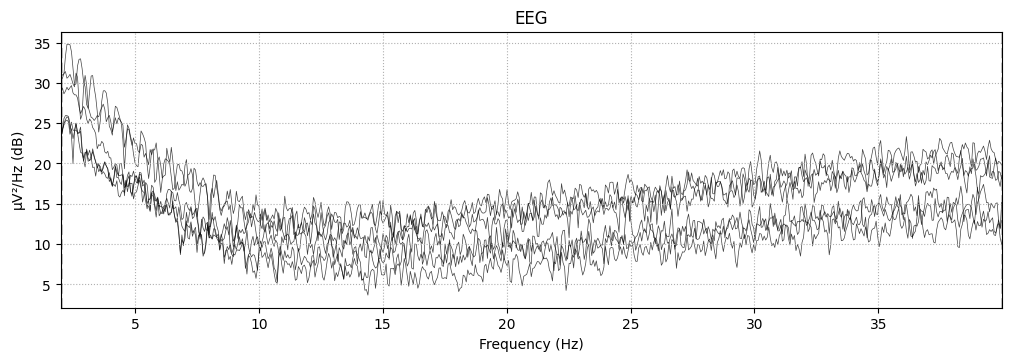

In [47]:
raw_filtered.copy().compute_psd(fmin=2, fmax=40).plot(picks="data", exclude="bads", spatial_colors=True)

In [26]:
events = mne.find_events(raw)
events

ValueError: No stim channels found. Consider specifying them manually using the 'stim_channel' parameter.

In [51]:
artifact_ts = [(5, 5.5), (7.4, 7.6)] # (start_sec, end_sec)
# ev_ts = noise_event_ts[0]
event_list = []
for ts in artifact_ts:
    new_events = mne.make_fixed_length_events(raw, start=ts[0], stop=ts[1], duration=ts[1]-ts[0], first_samp=False)
    event_list.append(new_events)
events = np.concatenate(event_list, axis=0)
# events
epochs = mne.Epochs(raw, events, event_id={'artifact': 1}, tmin=-0.25, tmax=0.25)
epochs.to_data_frame()
# evoked = epochs['stimulus'].average()
# evoked
# evoked.plot()
# new_events

Not setting metadata
2 matching events found
Setting baseline interval to [-0.248, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 63 original time points ...
0 bad epochs dropped


,time,condition,epoch,O1,T3,Fp1,Fp2,T4,O2
0,-0.248,artifact,0,-27.093337,-57.842867,39.686894,64.092772,-7.156141,20.937181
1,-0.240,artifact,0,-45.093062,-7.843630,36.686940,30.093291,-0.156248,-18.062224
2,-0.232,artifact,0,-51.092970,115.154493,46.686788,32.093260,65.842745,28.937058
3,-0.224,artifact,0,-20.093443,12.156065,39.686894,87.092421,52.842944,8.937364
4,-0.216,artifact,0,-38.093169,1.156232,36.686940,68.092711,2.843707,-24.062133
...,...,...,...,...,...,...,...,...,...
121,0.216,artifact,1,-32.718251,16.124754,-12.187314,-9.031112,116.029479,-49.499245
122,0.224,artifact,1,-1.718724,4.124937,-15.187268,-21.030929,17.030990,11.499825
123,0.232,artifact,1,23.280895,-24.874620,-5.187421,-29.030807,-53.967926,31.499519
124,0.240,artifact,1,2.281215,37.124434,1.812472,-25.030868,-32.968247,-22.499657


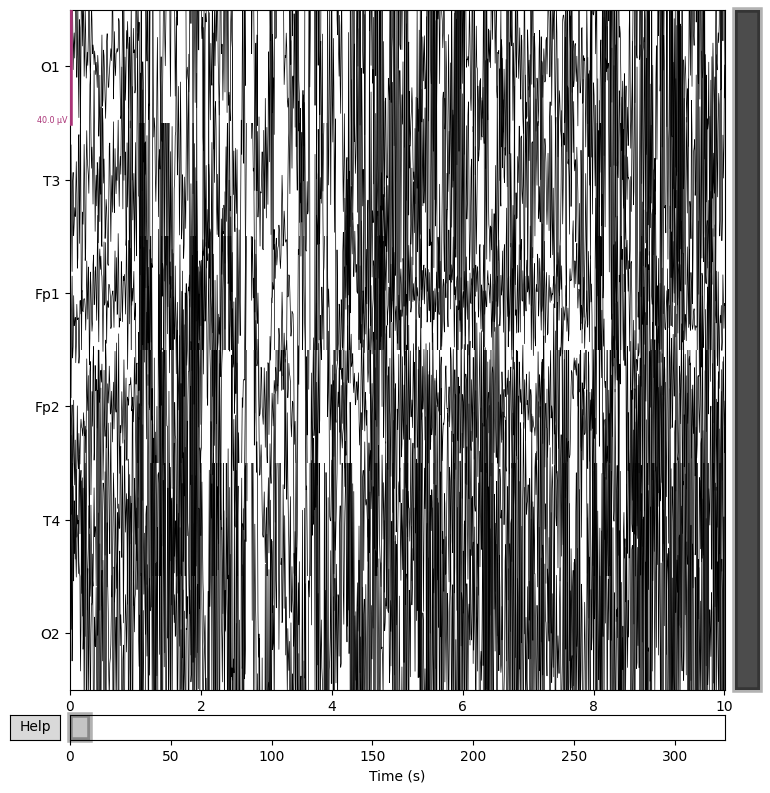

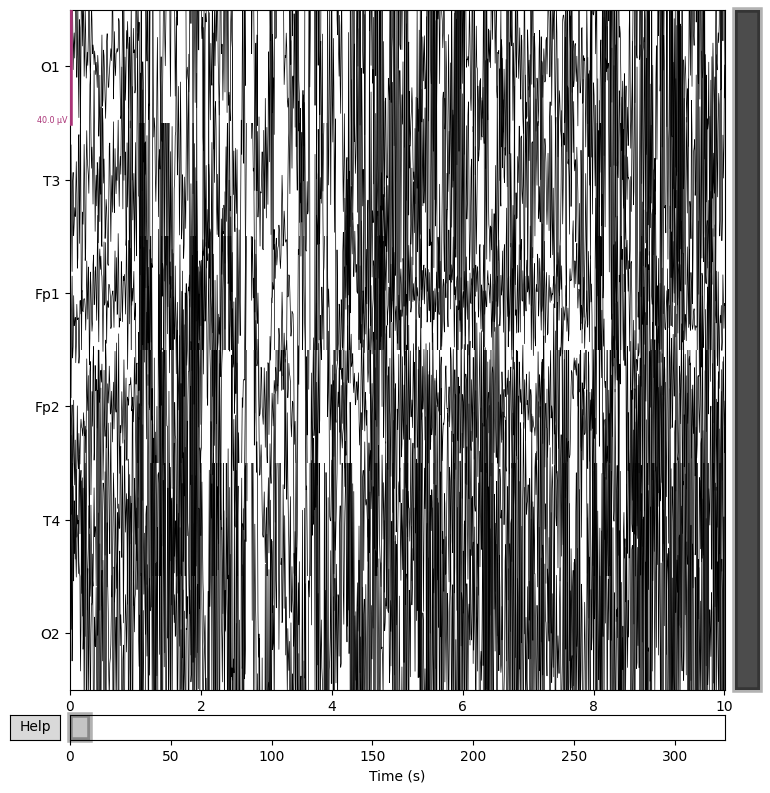

In [10]:
raw_filtered.plot()